In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('sonar.all-data', header=None)

In [3]:
df.isna().sum().sum()

0

In [4]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='60', ylabel='count'>

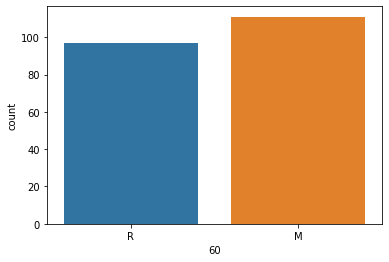

In [5]:
sns.countplot(df[60])

In [6]:
df = df.sample(frac=1)

In [7]:
df[60] = pd.factorize(df[60])[0]

In [8]:
def to_dataloader(df, target_col, batch_size):
    target = torch.tensor(df[target_col].values.astype(np.float32))
    data = torch.tensor(df.drop(target_col, axis=1).values.astype(np.float32))

    data_tensor = torch.utils.data.TensorDataset(data, target)
    data_loader = DataLoader(data_tensor, shuffle=True, batch_size=batch_size)
    return data_loader

In [9]:
class Classifier_nn(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, activation_function):
        super(Classifier_nn, self).__init__()
        self.activation_function = activation_function
        self.fcs = nn.ModuleList()
        self.bcs = nn.ModuleList()
        self.n_layers = n_layers
        self.fcs.append(nn.Linear(input_size, hidden_size[0]))
        self.bcs.append(nn.BatchNorm1d(hidden_size[0]))
        for i in range(self.n_layers - 1):
            self.fcs.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            self.bcs.append(nn.BatchNorm1d(hidden_size[i + 1]))
        self.fcs.append(nn.Linear(hidden_size[-1], output_size))
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.bcs[i](self.activation_function(self.fcs[i](x)))
        x = self.fcs[self.n_layers](x)
        x = x.squeeze(1)
        return x

In [10]:
def train(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    epochs_acc = []
    epochs_loss = []
    epochs_acc_test = []
    epochs_loss_test = []
    for epoch in tqdm(range(n_epochs), leave=False):
        batchs_acc = []
        batchs_loss = []
        for data, targets in train_loader:
            targets = targets.type(torch.LongTensor)
            outputs = model(data)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                _, preds = outputs.max(1)
                acc = (preds == targets).sum() / len(targets)
            batchs_acc.append(acc.item())
            batchs_loss.append(loss.item())
        
        epochs_acc.append(np.mean(batchs_acc))
        epochs_loss.append(np.mean(batchs_loss))
        batchs_acc_test, batchs_loss_test, _, _ = check_accuracy(model, test_loader, criterion)
        epochs_acc_test.append(batchs_acc_test)
        epochs_loss_test.append(batchs_loss_test)
    return epochs_acc, epochs_loss, epochs_acc_test, epochs_loss_test

In [11]:
def check_accuracy(model, loader, criterion):
    model.eval()
    targets_agg = np.array([])
    outputs_agg = np.array([])
    with torch.no_grad():
        batchs_acc = []
        batchs_loss = []
        for data, targets in loader:
            targets_agg = np.append(targets_agg, targets.numpy())
            targets = targets.type(torch.LongTensor)
            outputs = model(data)
            _, preds = outputs.max(1)
            outputs_agg = np.append(outputs_agg, preds.numpy())
            loss = criterion(outputs, targets)
            acc = (preds == targets).sum() / len(targets)
            batchs_acc.append(acc.item())     
            batchs_loss.append(loss.item())
    print('accuracy: {}, loss: {}'.format(np.mean(batchs_acc), np.mean(batchs_loss)))
    model.train()
    return np.mean(batchs_acc), np.mean(batchs_loss), outputs_agg, targets_agg

In [12]:
def plot_predictions(outputs_agg, test_loader):
    fig = plt.figure(figsize=(10, 10))
    targets = np.array([])
    for _, target in test_loader:
        targets = np.append(targets, target)
    sns.scatterplot(y=outputs_agg, x=targets)
    plt.ylabel('predictions')
    plt.xlabel('targets')

In [13]:
def plot_losses(epochs_acc, epochs_loss, epochs_acc_test, epochs_loss_test, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    sns.lineplot(data=epochs_acc, label='train data', ax=axs[0])
    sns.lineplot(data=epochs_acc_test, label='test data', ax=axs[0])
    axs[0].grid()
    axs[0].set_title('Acc per epoch')
    sns.lineplot(data=epochs_loss, label='train data', ax=axs[1])
    sns.lineplot(data=epochs_loss_test, label='test data', ax=axs[1])
    axs[1].grid()
    axs[1].set_title('CrossEntropy loss per epoch')
    plt.tight_layout()

In [14]:
def test_model(df, input_size, n_layers, hidden_size, activation_function, output_size, lr, n_epochs, batch_size):
    df = df.copy()
    train_df = df.sample(frac=.8)
    test_df = df.drop(train_df.index)
    train_loader = to_dataloader(
        df=train_df, 
        target_col=60, 
        batch_size=batch_size
    )
    test_loader = to_dataloader(
        df=test_df, 
        target_col=60, 
        batch_size=batch_size
    )
    model = Classifier_nn(
        input_size=input_size, 
        hidden_size=hidden_size, 
        n_layers=n_layers, 
        output_size=output_size, 
        activation_function=activation_function
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)
    epochs_acc, epochs_loss, epochs_acc_test, epochs_loss_test = train(
        model, 
        train_loader,
        test_loader,
        criterion,
        optimizer, 
        n_epochs
    )
    plot_losses(
        epochs_acc,
        epochs_loss,
        epochs_acc_test,
        epochs_loss_test,
        'CrossEntropyLoss, and {} layers used for training'.format(str(len(hidden_size)))
    )
    _, _, outputs_agg, targets_agg = check_accuracy(model, test_loader, criterion)
    fig = plt.figure()
    sns.heatmap(confusion_matrix(y_true=targets_agg, y_pred=outputs_agg), annot=True)
    print(classification_report(y_pred=outputs_agg, y_true=targets_agg))

Main model

  0%|          | 0/200 [00:00<?, ?it/s]

accuracy: 0.5583333373069763, loss: 0.6969504753748575
accuracy: 0.4958333373069763, loss: 0.7664887309074402
accuracy: 0.5083333353201548, loss: 0.7641348441441854
accuracy: 0.5416666666666666, loss: 0.7444597681363424
accuracy: 0.5708333353201548, loss: 0.7090731461842855
accuracy: 0.5625, loss: 0.6799760063489279
accuracy: 0.5958333412806193, loss: 0.6651536623636881
accuracy: 0.6166666746139526, loss: 0.6608460744222006
accuracy: 0.5916666686534882, loss: 0.6644314130147299
accuracy: 0.6708333293596903, loss: 0.6202710866928101
accuracy: 0.6208333373069763, loss: 0.6199045976003011
accuracy: 0.6083333293596903, loss: 0.6183181007703146
accuracy: 0.6833333373069763, loss: 0.6136335730552673
accuracy: 0.649999996026357, loss: 0.629448672135671
accuracy: 0.6916666626930237, loss: 0.6130169828732809
accuracy: 0.6583333412806193, loss: 0.6166372299194336
accuracy: 0.6458333333333334, loss: 0.5960309704144796
accuracy: 0.6791666746139526, loss: 0.6015225847562155
accuracy: 0.658333341280

accuracy: 0.850000003973643, loss: 0.32889517148335773
accuracy: 0.862499992052714, loss: 0.3401373227437337
accuracy: 0.850000003973643, loss: 0.375756174325943
accuracy: 0.850000003973643, loss: 0.35730787614981335
accuracy: 0.837499996026357, loss: 0.38315217693646747
accuracy: 0.862499992052714, loss: 0.3339186410109202
accuracy: 0.8291666706403097, loss: 0.37076730529467267
accuracy: 0.862499992052714, loss: 0.3191198805967967
accuracy: 0.850000003973643, loss: 0.30386828382809955
accuracy: 0.8833333253860474, loss: 0.29506343106428784
accuracy: 0.8958333333333334, loss: 0.2878335515658061
accuracy: 0.8416666587193807, loss: 0.3401167293389638
accuracy: 0.862499992052714, loss: 0.3266022404034932
accuracy: 0.8958333333333334, loss: 0.28602386514345807
accuracy: 0.850000003973643, loss: 0.3393997351328532
accuracy: 0.862499992052714, loss: 0.30952657759189606
accuracy: 0.8708333373069763, loss: 0.32953578730424243
accuracy: 0.9041666587193807, loss: 0.2971608191728592
accuracy: 0.8

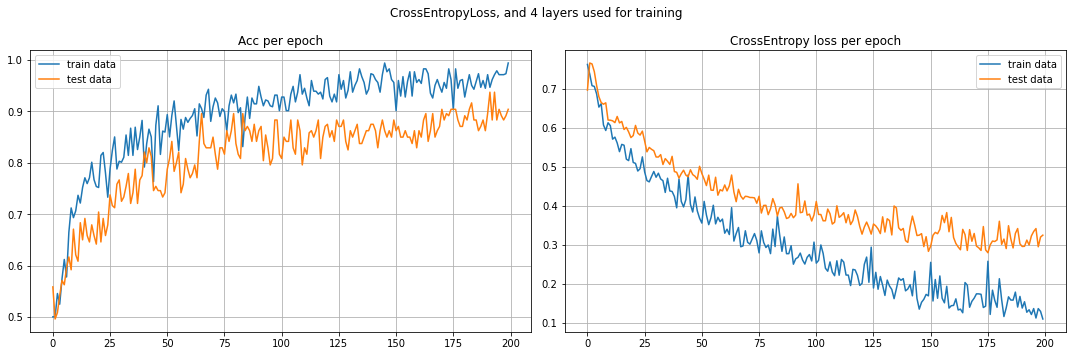

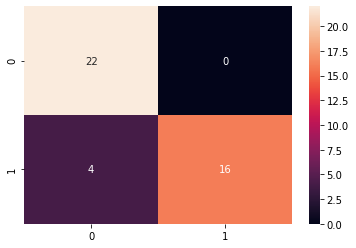

In [15]:
test_model(df, df.shape[1] - 1, 4, [50, 30, 16, 8], F.relu, 2, 0.0001, 200, 16)

Using different number of epochs 32, 64, 128

  0%|          | 0/200 [00:00<?, ?it/s]

accuracy: 0.4156250059604645, loss: 0.7382317185401917
accuracy: 0.518750011920929, loss: 0.7017359435558319
accuracy: 0.518750011920929, loss: 0.6978446245193481
accuracy: 0.484375, loss: 0.6975225508213043
accuracy: 0.484375, loss: 0.6964440643787384
accuracy: 0.518750011920929, loss: 0.6620320975780487
accuracy: 0.534375011920929, loss: 0.6659461855888367
accuracy: 0.684374988079071, loss: 0.6182529926300049
accuracy: 0.596875011920929, loss: 0.6781656444072723
accuracy: 0.581250011920929, loss: 0.6635919511318207
accuracy: 0.53125, loss: 0.6739370226860046
accuracy: 0.46562500298023224, loss: 0.6682713627815247
accuracy: 0.668749988079071, loss: 0.6189534664154053
accuracy: 0.546875, loss: 0.6823606491088867
accuracy: 0.53125, loss: 0.6611693799495697
accuracy: 0.49687500298023224, loss: 0.7004769742488861
accuracy: 0.6187500059604645, loss: 0.6195326745510101
accuracy: 0.565625011920929, loss: 0.6351645588874817
accuracy: 0.4625000059604645, loss: 0.7108064889907837
accuracy: 0.56

accuracy: 0.859375, loss: 0.3920951932668686
accuracy: 0.840624988079071, loss: 0.4162672758102417
accuracy: 0.840624988079071, loss: 0.418438196182251
accuracy: 0.7750000059604645, loss: 0.4278101176023483
accuracy: 0.7906250059604645, loss: 0.4122958332300186
accuracy: 0.7906250059604645, loss: 0.44127070903778076
accuracy: 0.824999988079071, loss: 0.38801446557044983
accuracy: 0.875, loss: 0.3789582699537277
accuracy: 0.7906250059604645, loss: 0.401031956076622
accuracy: 0.824999988079071, loss: 0.4028821736574173
accuracy: 0.7750000059604645, loss: 0.41159161925315857
accuracy: 0.7750000059604645, loss: 0.41153135895729065
accuracy: 0.7906250059604645, loss: 0.41323524713516235
accuracy: 0.8062500059604645, loss: 0.41928766667842865
accuracy: 0.840624988079071, loss: 0.39815448224544525
accuracy: 0.824999988079071, loss: 0.3749934434890747
accuracy: 0.859375, loss: 0.3374377489089966
accuracy: 0.7906250059604645, loss: 0.4197559654712677
accuracy: 0.7718749940395355, loss: 0.456995

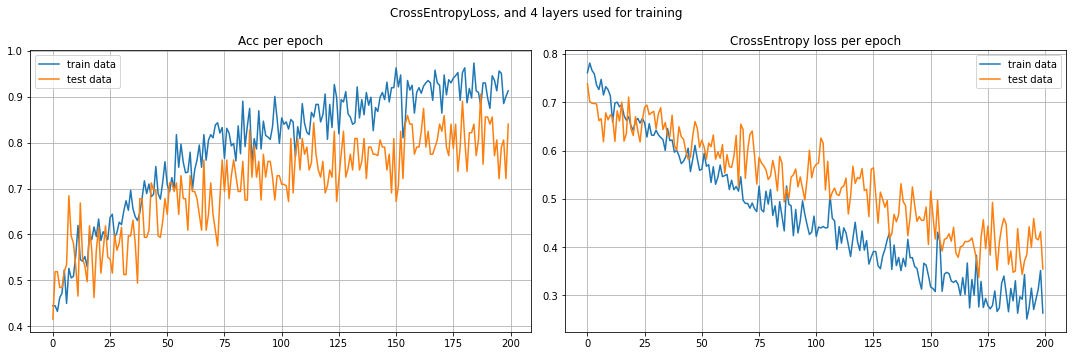

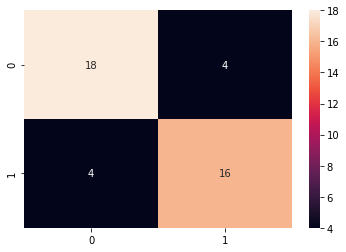

In [16]:
test_model(df, df.shape[1] - 1, 4, [50, 30, 16, 8], F.relu, 2, 0.0001, 200, 32)

  0%|          | 0/200 [00:00<?, ?it/s]

accuracy: 0.5714285969734192, loss: 0.6842290163040161
accuracy: 0.5714285969734192, loss: 0.6837963461875916
accuracy: 0.5714285969734192, loss: 0.6831933259963989
accuracy: 0.5714285969734192, loss: 0.6825380921363831
accuracy: 0.5714285969734192, loss: 0.6818791031837463
accuracy: 0.5714285969734192, loss: 0.6830845475196838
accuracy: 0.5952380895614624, loss: 0.6875176429748535
accuracy: 0.5714285969734192, loss: 0.6929358839988708
accuracy: 0.4761904776096344, loss: 0.7011744379997253
accuracy: 0.4761904776096344, loss: 0.7096025943756104
accuracy: 0.5, loss: 0.7163599729537964
accuracy: 0.5, loss: 0.7210142612457275
accuracy: 0.5, loss: 0.7217727303504944
accuracy: 0.5, loss: 0.7236917018890381
accuracy: 0.5, loss: 0.7269290685653687
accuracy: 0.5, loss: 0.730029284954071
accuracy: 0.523809552192688, loss: 0.729193925857544
accuracy: 0.523809552192688, loss: 0.7290416955947876
accuracy: 0.523809552192688, loss: 0.7317226529121399
accuracy: 0.4761904776096344, loss: 0.732526481151

accuracy: 0.6666666865348816, loss: 0.6719388365745544
accuracy: 0.6428571343421936, loss: 0.6761747002601624
accuracy: 0.6428571343421936, loss: 0.6747971773147583
accuracy: 0.6428571343421936, loss: 0.6750185489654541
accuracy: 0.6428571343421936, loss: 0.6672124862670898
accuracy: 0.6428571343421936, loss: 0.6606663465499878
accuracy: 0.6428571343421936, loss: 0.6555379033088684
accuracy: 0.6666666865348816, loss: 0.6593571305274963
accuracy: 0.6666666865348816, loss: 0.656751811504364
accuracy: 0.6666666865348816, loss: 0.6529080271720886
accuracy: 0.6666666865348816, loss: 0.6501088738441467
accuracy: 0.6666666865348816, loss: 0.6516705751419067
accuracy: 0.6904761791229248, loss: 0.6522952914237976
accuracy: 0.6904761791229248, loss: 0.6521115303039551
accuracy: 0.6904761791229248, loss: 0.6548987627029419
accuracy: 0.6904761791229248, loss: 0.6533350944519043
accuracy: 0.6666666865348816, loss: 0.6466875672340393
accuracy: 0.6666666865348816, loss: 0.6536852717399597
accuracy: 0

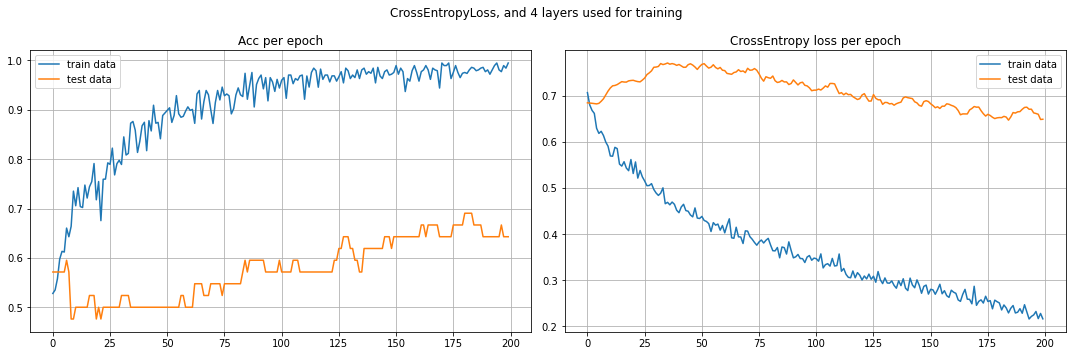

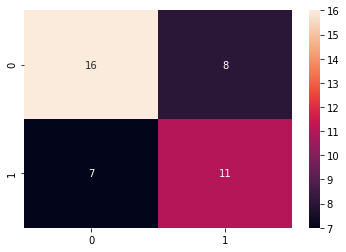

In [17]:
test_model(df, df.shape[1] - 1, 4, [50, 30, 16, 8], F.relu, 2, 0.0001, 200, 64)

  0%|          | 0/200 [00:00<?, ?it/s]

accuracy: 0.4761904776096344, loss: 0.6956005692481995
accuracy: 0.4761904776096344, loss: 0.6950119137763977
accuracy: 0.4761904776096344, loss: 0.6943795084953308
accuracy: 0.4761904776096344, loss: 0.6936526298522949
accuracy: 0.523809552192688, loss: 0.6931599378585815
accuracy: 0.523809552192688, loss: 0.693153440952301
accuracy: 0.4523809552192688, loss: 0.6931206583976746
accuracy: 0.4523809552192688, loss: 0.6930150985717773
accuracy: 0.523809552192688, loss: 0.6924193501472473
accuracy: 0.4761904776096344, loss: 0.6913347244262695
accuracy: 0.4523809552192688, loss: 0.6905179619789124
accuracy: 0.4761904776096344, loss: 0.6904287934303284
accuracy: 0.4761904776096344, loss: 0.6899358034133911
accuracy: 0.4761904776096344, loss: 0.6899449229240417
accuracy: 0.4761904776096344, loss: 0.6893154978752136
accuracy: 0.5, loss: 0.6867569088935852
accuracy: 0.5, loss: 0.6835490465164185
accuracy: 0.5, loss: 0.6820496916770935
accuracy: 0.523809552192688, loss: 0.6823312640190125
accur

accuracy: 0.761904776096344, loss: 0.5074667930603027
accuracy: 0.761904776096344, loss: 0.5075996518135071
accuracy: 0.761904776096344, loss: 0.5092070698738098
accuracy: 0.761904776096344, loss: 0.509204089641571
accuracy: 0.761904776096344, loss: 0.5109204053878784
accuracy: 0.761904776096344, loss: 0.5128005743026733
accuracy: 0.761904776096344, loss: 0.5181690454483032
accuracy: 0.7857142686843872, loss: 0.5184821486473083
accuracy: 0.7857142686843872, loss: 0.5175179839134216
accuracy: 0.7857142686843872, loss: 0.514525294303894
accuracy: 0.7857142686843872, loss: 0.5169549584388733
accuracy: 0.7857142686843872, loss: 0.5132892727851868
accuracy: 0.7857142686843872, loss: 0.5113648772239685
accuracy: 0.7857142686843872, loss: 0.5117064714431763
accuracy: 0.7857142686843872, loss: 0.5129616856575012
accuracy: 0.7857142686843872, loss: 0.5104464292526245
accuracy: 0.7857142686843872, loss: 0.5100421905517578
accuracy: 0.7857142686843872, loss: 0.5105046033859253
accuracy: 0.7857142

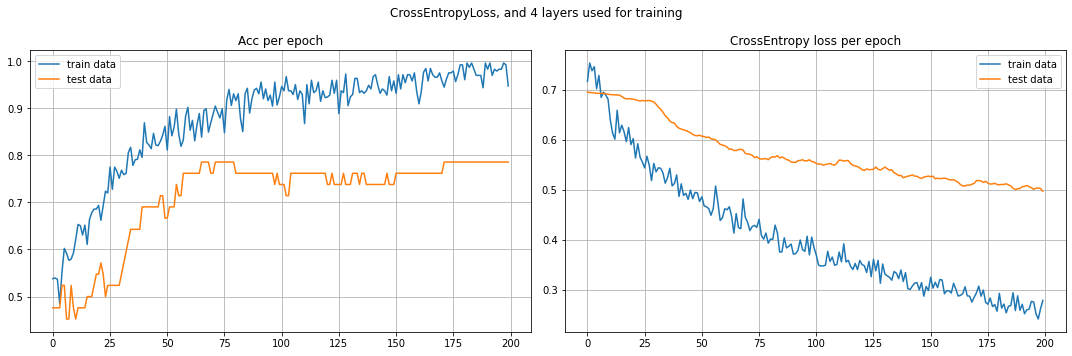

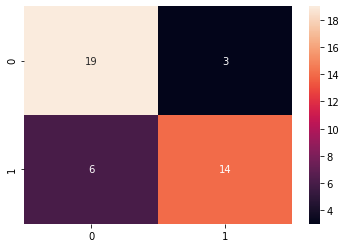

In [18]:
test_model(df, df.shape[1] - 1, 4, [50, 30, 16, 8], F.relu, 2, 0.0001, 200, 128)

Using different activation function for the hidden layers

  0%|          | 0/200 [00:00<?, ?it/s]

accuracy: 0.600000003973643, loss: 0.6867920756340027
accuracy: 0.462499996026357, loss: 0.6976173321406046
accuracy: 0.4375, loss: 0.7086522579193115
accuracy: 0.412500003973643, loss: 0.71697070201238
accuracy: 0.45000000794728595, loss: 0.6996878981590271
accuracy: 0.587499996026357, loss: 0.6649725437164307
accuracy: 0.7291666666666666, loss: 0.6291859149932861
accuracy: 0.7458333373069763, loss: 0.6270095705986023
accuracy: 0.725000003973643, loss: 0.625955065091451
accuracy: 0.7333333293596903, loss: 0.6221442222595215
accuracy: 0.7916666666666666, loss: 0.5863751570383707
accuracy: 0.7791666587193807, loss: 0.5955713192621866
accuracy: 0.712499996026357, loss: 0.5929417808850607
accuracy: 0.7416666746139526, loss: 0.5910734236240387
accuracy: 0.7583333253860474, loss: 0.552808920542399
accuracy: 0.7208333412806193, loss: 0.5632667342821757
accuracy: 0.725000003973643, loss: 0.5519268016020457
accuracy: 0.7333333293596903, loss: 0.5604414145151774
accuracy: 0.7083333333333334, lo

accuracy: 0.787500003973643, loss: 0.36164512236913043
accuracy: 0.8208333253860474, loss: 0.355888436237971
accuracy: 0.8416666587193807, loss: 0.376646230618159
accuracy: 0.8416666587193807, loss: 0.35780394574006397
accuracy: 0.8291666706403097, loss: 0.34278059999148053
accuracy: 0.8291666706403097, loss: 0.3498440484205882
accuracy: 0.837499996026357, loss: 0.37296446164449054
accuracy: 0.8416666587193807, loss: 0.35892124970753986
accuracy: 0.850000003973643, loss: 0.3936066726843516
accuracy: 0.8291666706403097, loss: 0.3457505206267039
accuracy: 0.875, loss: 0.321957806746165
accuracy: 0.8166666626930237, loss: 0.3688562611738841
accuracy: 0.8416666587193807, loss: 0.3490297297636668
accuracy: 0.8583333293596903, loss: 0.38182246188322705
accuracy: 0.862499992052714, loss: 0.36365237832069397
accuracy: 0.8166666626930237, loss: 0.3826089600721995
accuracy: 0.7958333293596903, loss: 0.3920085628827413
accuracy: 0.8041666746139526, loss: 0.380559782187144
accuracy: 0.795833329359

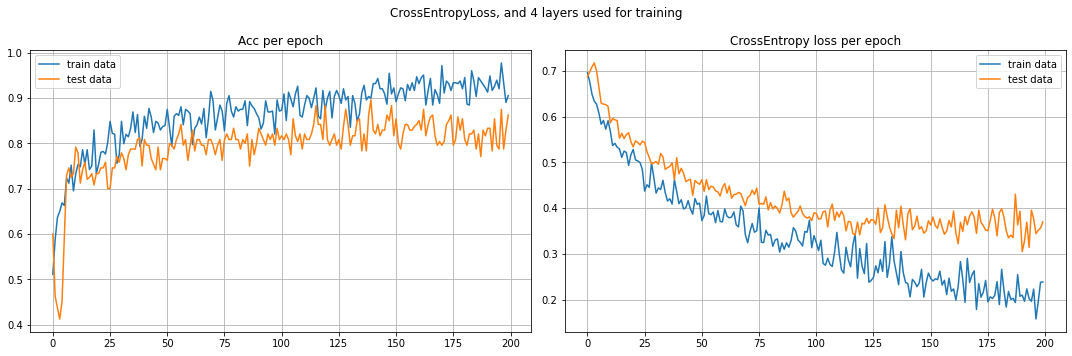

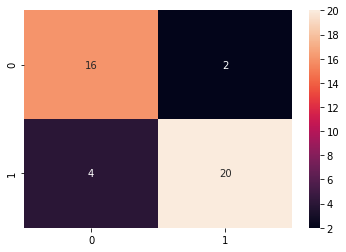

In [19]:
test_model(df, df.shape[1] - 1, 4, [50, 30, 16, 8], torch.sigmoid, 2, 0.0001, 200, 16)

  0%|          | 0/200 [00:00<?, ?it/s]

accuracy: 0.5583333373069763, loss: 0.6884513099988302
accuracy: 0.6416666706403097, loss: 0.6723067959149679
accuracy: 0.6083333293596903, loss: 0.6492055654525757
accuracy: 0.6583333412806193, loss: 0.6327460408210754
accuracy: 0.6583333412806193, loss: 0.6139571269353231
accuracy: 0.7791666587193807, loss: 0.5784047245979309
accuracy: 0.7541666626930237, loss: 0.5822126468022665
accuracy: 0.7291666666666666, loss: 0.5853742559750875
accuracy: 0.774999996026357, loss: 0.5707070430119833
accuracy: 0.7958333293596903, loss: 0.5627370675404867
accuracy: 0.7208333412806193, loss: 0.5526128709316254
accuracy: 0.725000003973643, loss: 0.5347398618857065
accuracy: 0.7791666587193807, loss: 0.5236486991246542
accuracy: 0.7791666587193807, loss: 0.5228614807128906
accuracy: 0.7416666746139526, loss: 0.5574562350908915
accuracy: 0.774999996026357, loss: 0.5371205906073252
accuracy: 0.7541666626930237, loss: 0.5344744523366293
accuracy: 0.7666666706403097, loss: 0.5321136911710104
accuracy: 0.7

accuracy: 0.8416666587193807, loss: 0.45822998881340027
accuracy: 0.8291666706403097, loss: 0.4602532982826233
accuracy: 0.8541666666666666, loss: 0.42796993752320606
accuracy: 0.8291666706403097, loss: 0.4522695740063985
accuracy: 0.8291666706403097, loss: 0.45804203550020856
accuracy: 0.8416666587193807, loss: 0.4480079412460327
accuracy: 0.8541666666666666, loss: 0.4212682197491328
accuracy: 0.8041666746139526, loss: 0.5164770483970642
accuracy: 0.8291666706403097, loss: 0.4541886895895004
accuracy: 0.862499992052714, loss: 0.43477677305539447
accuracy: 0.8541666666666666, loss: 0.4205096364021301
accuracy: 0.8416666587193807, loss: 0.4429246286551158
accuracy: 0.8541666666666666, loss: 0.437235747774442
accuracy: 0.850000003973643, loss: 0.47159746289253235
accuracy: 0.8541666666666666, loss: 0.41728832324345905
accuracy: 0.8416666587193807, loss: 0.4392026464144389
accuracy: 0.850000003973643, loss: 0.4345874985059102
accuracy: 0.862499992052714, loss: 0.4370238582293193
accuracy:

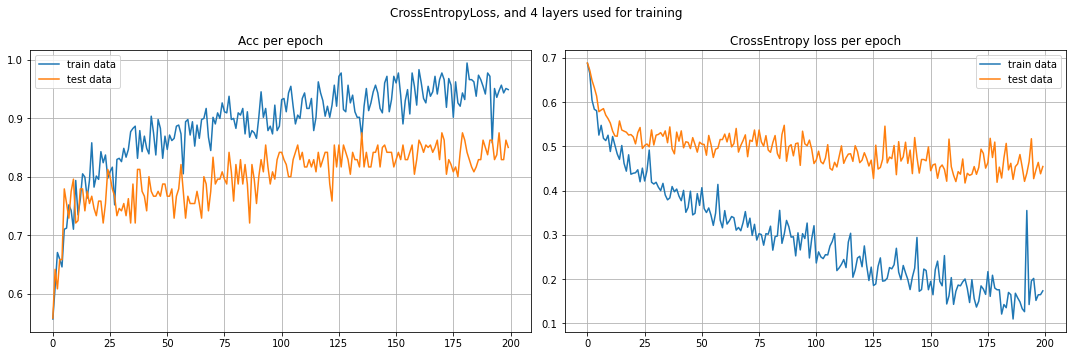

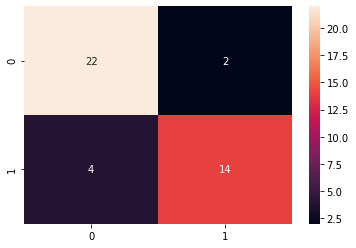

In [20]:
test_model(df, df.shape[1] - 1, 4, [50, 30, 16, 8], torch.tanh, 2, 0.0001, 200, 16)